https://www.kaggle.com/c/grupo-bimbo-inventory-demand/overview

In [1]:
import pandas as pd
import numpy as np
import os
from itertools import combinations
from tqdm import tqdm_notebook
import pickle
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
clients_table = pd.read_csv('../data/grupo-bimbo-inventory-demand/cliente_tabla.csv', index_col=0)
products_table = pd.read_csv('../data/grupo-bimbo-inventory-demand/producto_tabla.csv', index_col=0)
town_state_table = pd.read_csv('../data/grupo-bimbo-inventory-demand/town_state.csv', index_col=0)

In [4]:
# Переименуем колонки основного датасета для удобства
train_cols_map = {'Semana': 'Week', 'Agencia_ID': 'Sales_depot_ID', 'Canal_ID': 'Sales_channel_ID',
                  'Ruta_SAK': 'Route_ID', 'Cliente_ID': 'Client_ID', 'NombreCliente': 'Client_name',
                  'Producto_ID': 'Product_ID', 'NombreProducto': 'Product_name',
                  'Venta_uni_hoy': 'Sales_unit_this_week', 'Venta_hoy': 'Sales_this_week_pesos',
                  'Dev_uni_proxima': 'Returns_unit_next_week', 'Dev_proxima': 'Returns_next_week_pesos',
                  'Demanda_uni_equil': 'Adjusted_demand'
               }

In [5]:
types = {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,
         'Ruta_SAK':np.uint16, 'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,
         'Venta_uni_hoy': np.uint16, 'Venta_hoy': np.float32,
         'Demanda_uni_equil':np.uint32}

train_data = pd.read_csv('../data/grupo-bimbo-inventory-demand/train.csv', dtype=types)

In [6]:
train_data.rename(columns=train_cols_map, inplace=True)

In [7]:
train_data.head()

,Week,Sales_depot_ID,Sales_channel_ID,Route_ID,Client_ID,Product_ID,Sales_unit_this_week,Sales_this_week_pesos,Returns_unit_next_week,Returns_next_week_pesos,Adjusted_demand
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.320000,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.520000,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.920000,0,0.0,3


In [9]:
train_data.shape

(74180464, 11)

У нас есть более 74 млн. записей за 7 недель в тренировочном датасете. Есть также:
* количество продаж в штуках и в пессо,
* количество возвратов в штуках и в пессо
* целевая переменная (Adjusted_demand)

Нам нужно предсказывать спрос на определенный продукт в определенном магазине определенным клиентом за следующую неделю (Product_ID x Sales_depot_ID x Client_ID). Столбцы с суффиксом ID - категориальные, остальные - числовые. В тестовом наборе данных есть только категориальные столбцы.

In [10]:
train_data['Week'].unique()

array([3, 4, 5, 6, 7, 8, 9], dtype=uint64)

In [11]:
print('Сколько уникальных значений в колонках *_ID?\n')
for c in ['Sales_depot_ID', 'Sales_channel_ID', 'Route_ID', 'Client_ID', 'Product_ID']:
    print(f'{c}: {train_data[c].nunique()}')

Сколько уникальных значений в колонках *_ID?

Sales_depot_ID: 552
Sales_channel_ID: 9
Route_ID: 3603
Client_ID: 880604
Product_ID: 1799


## Клиенты

Самая многочисленная категория - Client_ID (более 880 тысяч значений). Есть табличка, связывающая ID и имя клиента. В комментариях к заданию написано, что эти данные сильно зашумлены.

In [12]:
clients_table.head()

,NombreCliente
Cliente_ID,
0,SIN NOMBRE
1,OXXO XINANTECATL
2,SIN NOMBRE
3,EL MORENO
4,SDN SER DE ALIM CUERPO SA CIA DE INT


In [13]:
clients_table.shape

(935362, 1)

In [14]:
clients_table.index.nunique()

930500

In [15]:
clients_table['NombreCliente'].nunique()

311155

Видим, что на 930 тыс. индексов приходится всего 311 тыс. уникальных имён. Количество уникальных индексов на 5000 меньше, чем записей в таблице. Можно сократить количество уникальных значений Client_ID в train/test датасете, выбрав только один из нескольких индексов для каждого имени и прописав его в основные таблицы. Также нужно отметить, что в таблице клиентов 935362 ID, а в train_data только 880604. Значит test_data есть Client_ID, которых нет в train_data.

Сколько единиц товара в неделю покупают клиенты?

In [16]:
clients_units_per_week = train_data.groupby(['Client_ID']).agg({'Adjusted_demand':'sum'})/7

In [17]:
clients_units_per_week

,Adjusted_demand
Client_ID,
26,911.142857
60,6690.000000
65,9819.285714
101,174.857143
105,2481.857143
...,...
11011586,584.857143
11693264,575.428571
19988629,18.714286


In [18]:
clients_units_per_week.describe()

,Adjusted_demand
count,8.806040e+05
mean,8.694057e+01
std,2.736530e+03
min,0.000000e+00
25%,1.128571e+01
50%,3.271429e+01
75%,8.528571e+01
max,2.552318e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2973f5c90>]],
      dtype=object)

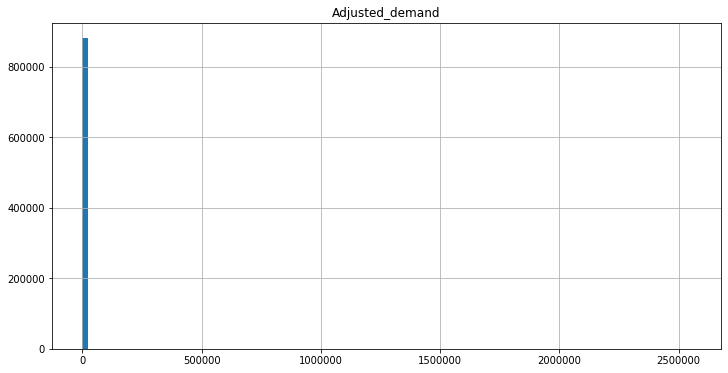

In [19]:
clients_units_per_week.hist(bins=100, figsize=(12,6))

75% клиентов берут ~ 85 единиц товара, но есть отдельные клиенты, которые закупают до 2.5 милн. единиц в неделю.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2972bfb10>]],
      dtype=object)

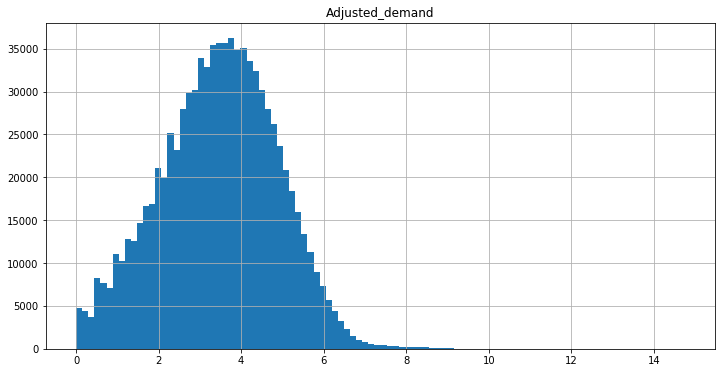

In [20]:
# В логарифмической шкале
np.log(clients_units_per_week + 1).hist(bins=100, figsize=(12,6))

In [21]:
print(f'Большинство клиентов берут {round(np.exp(3.9) - 1, 2)} единиц товаров в неделю.')

Большинство клиентов берут 48.4 единиц товаров в неделю.


In [22]:
clients_units_per_week.sort_values('Adjusted_demand').tail(10)

,Adjusted_demand
Client_ID,
19260,2.211171e+04
5903732,2.323329e+04
1200400,2.337014e+04
653037,2.342643e+04
2502084,2.591529e+04
653124,2.964957e+04
1216931,3.321029e+04
652850,6.286271e+04
653039,1.276794e+05


In [23]:
# Топ-10 самых крупных клиентов
inds = clients_units_per_week.sort_values('Adjusted_demand').tail(10).index
clients_table.loc[inds]

,NombreCliente
Cliente_ID,
19260,WAL MART TEPEYAC
5903732,WAL MART SUPER CENTER DOMINGO DIEZ CUERNAVACA
1200400,CHEDRAUI POLANCO
653037,OAXACA REMISION
2502084,CEDIS CADENA COMERCIAL OXXO
653124,TAMAULIPAS REMISION
1216931,OXXO TECNOLOGICO
652850,JALISCO REMISION
653039,QUERETARO DE ARTEAGA REMISION


In [24]:
# Сколько клиентов не покупают вообще ничего?
(clients_units_per_week['Adjusted_demand'] == 0).sum()

816

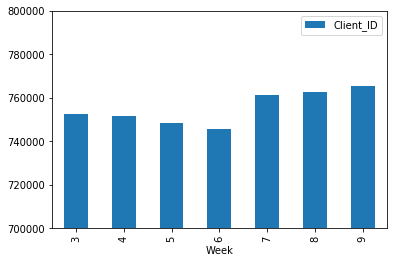

In [25]:
train_data.groupby(['Week']).agg({'Client_ID':'nunique'}).plot(kind='bar', ylim=(700000, 800000))

Количество уникальных клиентов меняется от недели к неделе. Значит далеко не все клиенты закупаются регулярно раз в неделю.

## Продукты

In [26]:
products_table.head(30)

,NombreProducto
Producto_ID,
0,NO IDENTIFICADO 0
9,Capuccino Moka 750g NES 9
41,Bimbollos Ext sAjonjoli 6p 480g BIM 41
53,Burritos Sincro 170g CU LON 53
72,Div Tira Mini Doradita 4p 45g TR 72
73,Pan Multigrano Linaza 540g BIM 73
98,Tostado Integral 180g WON 98
99,Pan Blanco 567g WON 99
100,Super Pan Bco Ajonjoli 680g SP WON 100


In [27]:
products_table.shape

(2592, 1)

In [28]:
products_table.index.nunique()

2592

In [29]:
products_table['NombreProducto'].nunique()

2592

В таблице продуктов нет повторов. В тексте описания продуктов есть количество/вес. Есть продукты с практически одинаковыми названиями: Bollos BK 4in 36p 1635g SL 131, Bollos BK 4in 30p 1635g TIR SL 134. Они отличаются количеством единиц в упаковке. Разделив описание товаров на составные части можно сгруппировать их по названию продукта. Однако, для клиента может быть важен размер упаковки или другие параметры товаров, поэтому нужно аккуратно использовать эти данные.

In [30]:
# Продажи продуктов в неделю
prodcut_sales_per_week = train_data.groupby('Product_ID').agg({'Adjusted_demand': 'sum'})/7

In [31]:
prodcut_sales_per_week.describe()

,Adjusted_demand
count,1.799000e+03
mean,4.255710e+04
std,1.927219e+05
min,0.000000e+00
25%,8.864286e+01
50%,1.263143e+03
75%,1.356207e+04
max,3.389811e+06


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2973e06d0>]],
      dtype=object)

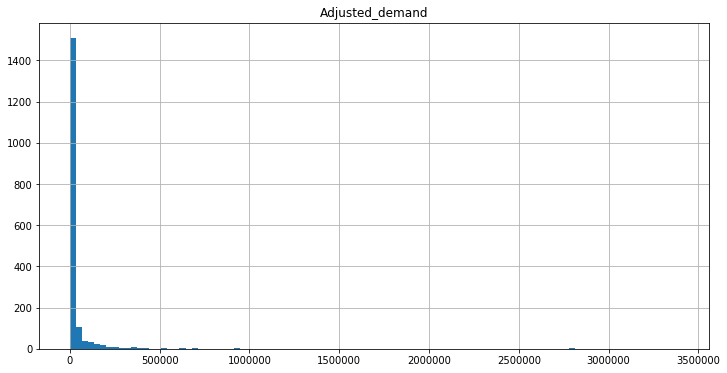

In [32]:
prodcut_sales_per_week.hist(bins=100, figsize=(12,6))

Опять видим длинный хвост распределения. Какие продукты продаются лучше всего?

In [33]:
bestsalers = prodcut_sales_per_week.sort_values('Adjusted_demand', ascending=False).iloc[:100]

In [34]:
bestsalers = bestsalers.join(products_table, on='Product_ID')

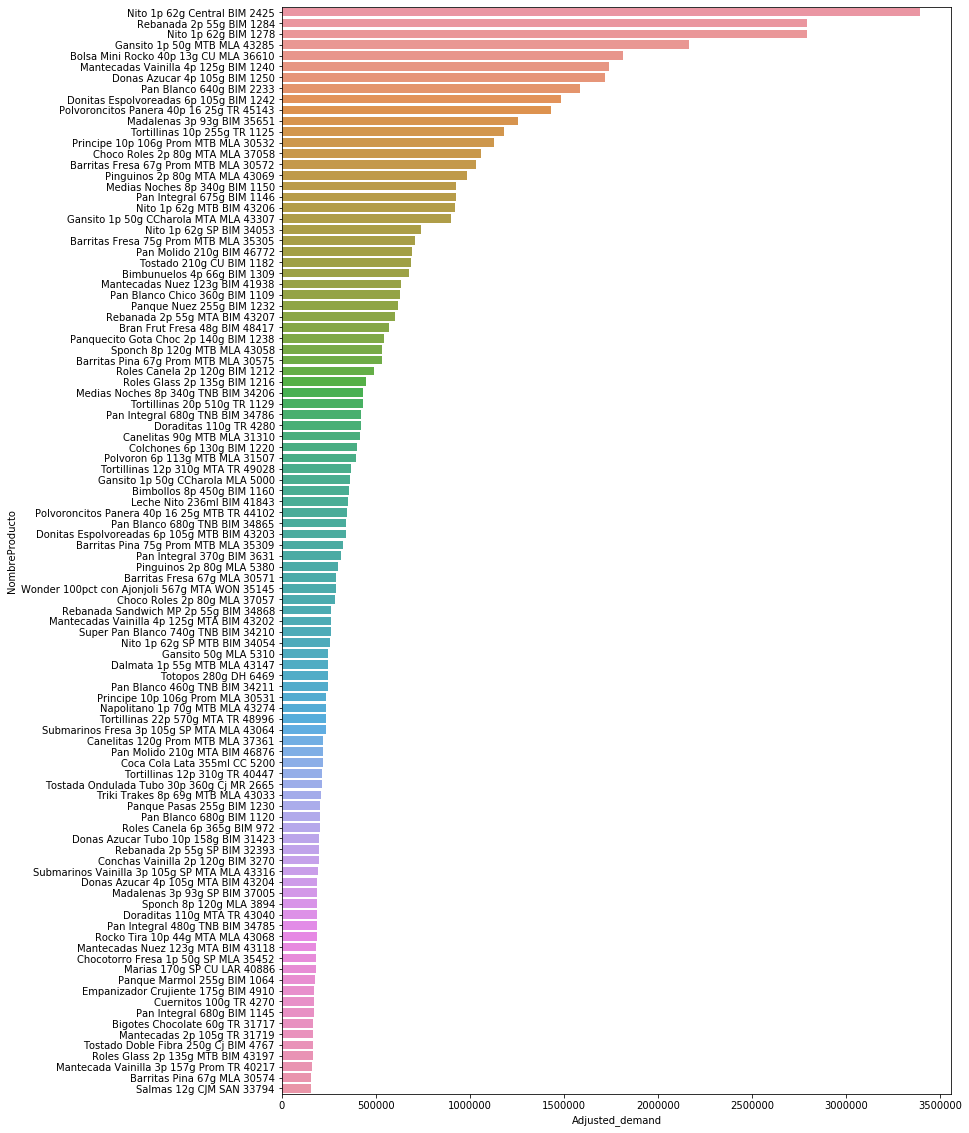

In [35]:
fig, ax = plt.subplots(figsize=(12,20))
sns.barplot(x='Adjusted_demand', y='NombreProducto', data=bestsalers, ax=ax)

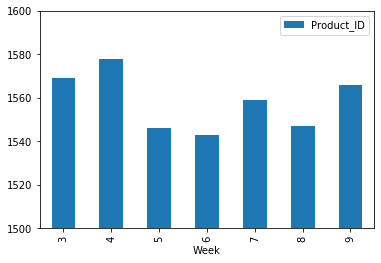

In [36]:
train_data.groupby(['Week']).agg({'Product_ID':'nunique'}).plot(kind='bar', ylim=(1500, 1600))

Количество уникальных наименований товаров незначительно меняется от недели к неделе.

## Точки продаж

In [37]:
train_data['Sales_depot_ID'].nunique()

552

In [38]:
train_data.groupby('Sales_depot_ID').agg({'Product_ID':'nunique'}).describe()

,Product_ID
count,552.000000
mean,150.269928
std,56.915175
min,6.000000
25%,106.000000
50%,159.000000
75%,189.000000
max,328.000000


В выборке 552 магазина. В них представлены в среднем 150 наименований товаров. Посмотрим на топ-100 магазинов по продажам в неделю.

In [39]:
sales_per_shop_per_week = train_data.groupby('Sales_depot_ID').agg({'Adjusted_demand':'sum'})/7
sales_per_shop_per_week.describe()

,Adjusted_demand
count,552.000000
mean,138696.042961
std,128578.405315
min,4567.571429
25%,40255.214286
50%,90010.571429
75%,202580.750000
max,756910.285714


In [40]:
best_shops = sales_per_shop_per_week.sort_values('Adjusted_demand', ascending=False).iloc[:100]

In [41]:
best_shops

,Adjusted_demand
Sales_depot_ID,
1911,756910.285714
1351,582161.571429
1912,570942.571429
1312,552438.428571
1347,541109.000000
...,...
2036,256687.857143
3214,255990.285714
1387,254415.428571


## Признаки

У нас есть пять категориальных признаков. Посчитаем статистики по целевой переменной в различных срезах. Например:

* средние продажи определенного товара в определенном магазине
* медианные продажи определенному клиенту в магазине
* суммарное количество продаж клиенту по определенному каналу продаж
* ...

Рассчитывать статистики будем по срезам из двух признаков для первых пяти недель. Поскольку для расчета признаков будем использовать целевую переменную, мы не сможем обучить модель на первых пяти неделях. Обучим её на шестой неделе (неделя №8 в датасете) и провалидируем на седьмой.

In [8]:
cat_columns = ['Sales_depot_ID', 'Sales_channel_ID', 'Route_ID', 'Client_ID', 'Product_ID']
slices = list(combinations(cat_columns, 2))

In [43]:
train_0 = train_data.loc[train_data['Week'] < 8, cat_columns + ['Adjusted_demand']]

In [44]:
# Посчитаем количество уникальных комбинаций значений признаков в каждом из срезов
# и создадим в датасете колонки для этих признаков
for sl in slices:
    name = f'C_{sl[0]}_x_{sl[1]}'
    train_0[name] = int(0)
    print(f'{name}: ', train_0.loc[:, [sl[0], sl[1]]].drop_duplicates().shape[0])

C_Sales_depot_ID_x_Sales_channel_ID:  780
C_Sales_depot_ID_x_Route_ID:  27221
C_Sales_depot_ID_x_Client_ID:  905797
C_Sales_depot_ID_x_Product_ID:  79177
C_Sales_channel_ID_x_Route_ID:  3948
C_Sales_channel_ID_x_Client_ID:  866668
C_Sales_channel_ID_x_Product_ID:  4940
C_Route_ID_x_Client_ID:  2145948
C_Route_ID_x_Product_ID:  235375
C_Client_ID_x_Product_ID:  22146628


In [45]:
# Данные признаки рассчитываются со скоростью ~10 итераций в секунду, 
# поэтому оставим только срезы, в которых меньше 300000 комбинаций
slices_reduced = [slices[0]] + [slices[1]] + [slices[3]] + [slices[4]] + [slices[6]] + [slices[8]]

In [32]:
slices_reduced

[('Sales_depot_ID', 'Sales_channel_ID'),
 ('Sales_depot_ID', 'Route_ID'),
 ('Sales_depot_ID', 'Product_ID'),
 ('Sales_channel_ID', 'Route_ID'),
 ('Sales_channel_ID', 'Product_ID'),
 ('Route_ID', 'Product_ID')]

In [108]:
%%time
for sl in slices_reduced:
    # будем сохранять расчеты в файлы, чтобы не потерять всю работу при сбое
    filename = f'C_{sl[0]}_x_{sl[1]}'
    
    # создадим двухуровневый индекс из комбинаций всех значений в двух категориальных столбцах
    index = pd.MultiIndex.from_frame(train_0.loc[:, [sl[0], sl[1]]].drop_duplicates())
    # series для хранения результатов расчетов
    counters = pd.Series(index=index)
    means = pd.Series(index=index)
    medians = pd.Series(index=index)
    
    for i1, i2 in tqdm_notebook(index.to_flat_index().values):
        # выбираем все значения для конкретного сочетания двух категориальных признаков 
        subset = train_0.loc[(train_0[sl[0]] == i1) & (train_0[sl[1]] == i2)]
        # считаем статистики по подмножеству
        counters[i1, i2] = subset['Adjusted_demand'].sum()
        means[i1, i2] = subset['Adjusted_demand'].mean()        
        medians[i1, i2] = subset['Adjusted_demand'].median()        
    
    # сохраняем расчеты по каждому срезу
    pickle.dump((counters, means, medians), open(f'../data/counters/{filename}.pkl', 'wb'))


CPU times: user 2d 9h 9min 14s, sys: 2h 32min, total: 2d 11h 41min 15s
Wall time: 9h 56min 34s


Расчёт признаков занял почти 10 часов.

## Модель

In [9]:
# создадим train и validation из данных за оставшиеся 8 и 9 недели 
train_1 = train_data.loc[train_data['Week'] == 8, cat_columns + ['Adjusted_demand']]
val_1 = train_data.loc[train_data['Week'] == 9, cat_columns + ['Adjusted_demand']]

In [2]:
# Базовая модель: CatBoostRegressor с параметрами по умолчанию на пяти категориальных признаках
from catboost import CatBoostRegressor

In [11]:
# пролагарифмируем целевую переменную, поскольку в соревновании используется RMSLE
y = np.log(train_1['Adjusted_demand']+1)
y_val = np.log(val_1['Adjusted_demand']+1)
model = CatBoostRegressor(task_type='GPU')
model.fit(train_1.iloc[:, :5], y, eval_set=(val_1.iloc[:, :5], y_val), cat_features=cat_columns)

0:	learn: 0.8302349	test: 0.8276795	best: 0.8276795 (0)	total: 2.04s	remaining: 34m 1s
1:	learn: 0.8193303	test: 0.8165380	best: 0.8165380 (1)	total: 3.5s	remaining: 29m 5s
2:	learn: 0.8087798	test: 0.8060363	best: 0.8060363 (2)	total: 5.27s	remaining: 29m 11s
3:	learn: 0.7986725	test: 0.7960275	best: 0.7960275 (3)	total: 7.04s	remaining: 29m 13s
4:	learn: 0.7887960	test: 0.7862950	best: 0.7862950 (4)	total: 9.03s	remaining: 29m 55s
5:	learn: 0.7795546	test: 0.7770805	best: 0.7770805 (5)	total: 10.8s	remaining: 29m 55s
6:	learn: 0.7705256	test: 0.7680381	best: 0.7680381 (6)	total: 12.8s	remaining: 30m 18s
7:	learn: 0.7620766	test: 0.7593826	best: 0.7593826 (7)	total: 14.2s	remaining: 29m 22s
8:	learn: 0.7539942	test: 0.7511988	best: 0.7511988 (8)	total: 16.2s	remaining: 29m 42s
9:	learn: 0.7460864	test: 0.7433932	best: 0.7433932 (9)	total: 18s	remaining: 29m 37s
10:	learn: 0.7386880	test: 0.7360429	best: 0.7360429 (10)	total: 19.7s	remaining: 29m 33s
11:	learn: 0.7315089	test: 0.728674

92:	learn: 0.5659721	test: 0.5556713	best: 0.5556713 (92)	total: 2m 22s	remaining: 23m 8s
93:	learn: 0.5655931	test: 0.5552708	best: 0.5552708 (93)	total: 2m 24s	remaining: 23m 11s
94:	learn: 0.5652288	test: 0.5548812	best: 0.5548812 (94)	total: 2m 25s	remaining: 23m 8s
95:	learn: 0.5649057	test: 0.5545338	best: 0.5545338 (95)	total: 2m 27s	remaining: 23m 7s
96:	learn: 0.5645976	test: 0.5542239	best: 0.5542239 (96)	total: 2m 28s	remaining: 23m 3s
97:	learn: 0.5642516	test: 0.5538527	best: 0.5538527 (97)	total: 2m 30s	remaining: 23m
98:	learn: 0.5639717	test: 0.5535446	best: 0.5535446 (98)	total: 2m 32s	remaining: 23m 3s
99:	learn: 0.5636170	test: 0.5531698	best: 0.5531698 (99)	total: 2m 33s	remaining: 23m 1s
100:	learn: 0.5633033	test: 0.5528142	best: 0.5528142 (100)	total: 2m 35s	remaining: 23m 1s
101:	learn: 0.5630493	test: 0.5525289	best: 0.5525289 (101)	total: 2m 36s	remaining: 22m 59s
102:	learn: 0.5627982	test: 0.5522589	best: 0.5522589 (102)	total: 2m 38s	remaining: 23m 2s
103:	

181:	learn: 0.5483832	test: 0.5367927	best: 0.5367927 (181)	total: 4m 45s	remaining: 21m 22s
182:	learn: 0.5483189	test: 0.5367115	best: 0.5367115 (182)	total: 4m 46s	remaining: 21m 20s
183:	learn: 0.5482310	test: 0.5366218	best: 0.5366218 (183)	total: 4m 48s	remaining: 21m 18s
184:	learn: 0.5481758	test: 0.5365600	best: 0.5365600 (184)	total: 4m 50s	remaining: 21m 18s
185:	learn: 0.5480181	test: 0.5364268	best: 0.5364268 (185)	total: 4m 51s	remaining: 21m 16s
186:	learn: 0.5478810	test: 0.5363157	best: 0.5363157 (186)	total: 4m 53s	remaining: 21m 15s
187:	learn: 0.5477351	test: 0.5362018	best: 0.5362018 (187)	total: 4m 54s	remaining: 21m 13s
188:	learn: 0.5475638	test: 0.5360636	best: 0.5360636 (188)	total: 4m 56s	remaining: 21m 12s
189:	learn: 0.5474710	test: 0.5359767	best: 0.5359767 (189)	total: 4m 57s	remaining: 21m 9s
190:	learn: 0.5473883	test: 0.5358905	best: 0.5358905 (190)	total: 4m 59s	remaining: 21m 7s
191:	learn: 0.5473006	test: 0.5358229	best: 0.5358229 (191)	total: 5m 1s

270:	learn: 0.5415371	test: 0.5306868	best: 0.5306868 (270)	total: 7m 9s	remaining: 19m 16s
271:	learn: 0.5414971	test: 0.5306536	best: 0.5306536 (271)	total: 7m 11s	remaining: 19m 13s
272:	learn: 0.5414394	test: 0.5305922	best: 0.5305922 (272)	total: 7m 12s	remaining: 19m 12s
273:	learn: 0.5413922	test: 0.5305497	best: 0.5305497 (273)	total: 7m 13s	remaining: 19m 9s
274:	learn: 0.5413359	test: 0.5305120	best: 0.5305120 (274)	total: 7m 15s	remaining: 19m 8s
275:	learn: 0.5412828	test: 0.5304706	best: 0.5304706 (275)	total: 7m 16s	remaining: 19m 5s
276:	learn: 0.5412112	test: 0.5304111	best: 0.5304111 (276)	total: 7m 18s	remaining: 19m 4s
277:	learn: 0.5411580	test: 0.5303408	best: 0.5303408 (277)	total: 7m 20s	remaining: 19m 3s
278:	learn: 0.5410956	test: 0.5302963	best: 0.5302963 (278)	total: 7m 21s	remaining: 19m 1s
279:	learn: 0.5410521	test: 0.5302518	best: 0.5302518 (279)	total: 7m 23s	remaining: 18m 59s
280:	learn: 0.5410186	test: 0.5302163	best: 0.5302163 (280)	total: 7m 24s	rem

359:	learn: 0.5379279	test: 0.5273651	best: 0.5273651 (359)	total: 9m 24s	remaining: 16m 44s
360:	learn: 0.5379051	test: 0.5273460	best: 0.5273460 (360)	total: 9m 26s	remaining: 16m 42s
361:	learn: 0.5378652	test: 0.5272982	best: 0.5272982 (361)	total: 9m 28s	remaining: 16m 41s
362:	learn: 0.5378386	test: 0.5272860	best: 0.5272860 (362)	total: 9m 29s	remaining: 16m 39s
363:	learn: 0.5378073	test: 0.5272557	best: 0.5272557 (363)	total: 9m 31s	remaining: 16m 38s
364:	learn: 0.5377650	test: 0.5272214	best: 0.5272214 (364)	total: 9m 32s	remaining: 16m 36s
365:	learn: 0.5377252	test: 0.5271786	best: 0.5271786 (365)	total: 9m 34s	remaining: 16m 34s
366:	learn: 0.5376980	test: 0.5271458	best: 0.5271458 (366)	total: 9m 35s	remaining: 16m 32s
367:	learn: 0.5376738	test: 0.5271310	best: 0.5271310 (367)	total: 9m 37s	remaining: 16m 31s
368:	learn: 0.5376410	test: 0.5270971	best: 0.5270971 (368)	total: 9m 38s	remaining: 16m 29s
369:	learn: 0.5375924	test: 0.5270551	best: 0.5270551 (369)	total: 9m 

447:	learn: 0.5354686	test: 0.5251281	best: 0.5251281 (447)	total: 11m 41s	remaining: 14m 24s
448:	learn: 0.5354496	test: 0.5251109	best: 0.5251109 (448)	total: 11m 44s	remaining: 14m 24s
449:	learn: 0.5354281	test: 0.5250907	best: 0.5250907 (449)	total: 11m 46s	remaining: 14m 23s
450:	learn: 0.5353961	test: 0.5250638	best: 0.5250638 (450)	total: 11m 47s	remaining: 14m 20s
451:	learn: 0.5353749	test: 0.5250554	best: 0.5250554 (451)	total: 11m 48s	remaining: 14m 19s
452:	learn: 0.5353496	test: 0.5250337	best: 0.5250337 (452)	total: 11m 50s	remaining: 14m 17s
453:	learn: 0.5353199	test: 0.5250097	best: 0.5250097 (453)	total: 11m 51s	remaining: 14m 16s
454:	learn: 0.5352967	test: 0.5249795	best: 0.5249795 (454)	total: 11m 53s	remaining: 14m 14s
455:	learn: 0.5352753	test: 0.5249563	best: 0.5249563 (455)	total: 11m 54s	remaining: 14m 12s
456:	learn: 0.5352575	test: 0.5249359	best: 0.5249359 (456)	total: 11m 56s	remaining: 14m 11s
457:	learn: 0.5352320	test: 0.5249061	best: 0.5249061 (457)	

535:	learn: 0.5336624	test: 0.5234944	best: 0.5234944 (535)	total: 13m 55s	remaining: 12m 3s
536:	learn: 0.5336499	test: 0.5234850	best: 0.5234850 (536)	total: 13m 56s	remaining: 12m 1s
537:	learn: 0.5336290	test: 0.5234674	best: 0.5234674 (537)	total: 13m 58s	remaining: 11m 59s
538:	learn: 0.5336163	test: 0.5234568	best: 0.5234568 (538)	total: 13m 59s	remaining: 11m 58s
539:	learn: 0.5336058	test: 0.5234514	best: 0.5234514 (539)	total: 14m 1s	remaining: 11m 56s
540:	learn: 0.5335888	test: 0.5234433	best: 0.5234433 (540)	total: 14m 2s	remaining: 11m 54s
541:	learn: 0.5335704	test: 0.5234272	best: 0.5234272 (541)	total: 14m 3s	remaining: 11m 53s
542:	learn: 0.5335494	test: 0.5234172	best: 0.5234172 (542)	total: 14m 5s	remaining: 11m 51s
543:	learn: 0.5335351	test: 0.5234086	best: 0.5234086 (543)	total: 14m 7s	remaining: 11m 50s
544:	learn: 0.5335182	test: 0.5233877	best: 0.5233877 (544)	total: 14m 8s	remaining: 11m 48s
545:	learn: 0.5335049	test: 0.5233755	best: 0.5233755 (545)	total: 1

623:	learn: 0.5322905	test: 0.5223623	best: 0.5223623 (623)	total: 16m 8s	remaining: 9m 43s
624:	learn: 0.5322799	test: 0.5223586	best: 0.5223586 (624)	total: 16m 10s	remaining: 9m 42s
625:	learn: 0.5322581	test: 0.5223359	best: 0.5223359 (625)	total: 16m 11s	remaining: 9m 40s
626:	learn: 0.5322508	test: 0.5223288	best: 0.5223288 (626)	total: 16m 13s	remaining: 9m 38s
627:	learn: 0.5322367	test: 0.5223097	best: 0.5223097 (627)	total: 16m 14s	remaining: 9m 37s
628:	learn: 0.5322270	test: 0.5222993	best: 0.5222993 (628)	total: 16m 15s	remaining: 9m 35s
629:	learn: 0.5322174	test: 0.5222921	best: 0.5222921 (629)	total: 16m 16s	remaining: 9m 33s
630:	learn: 0.5321922	test: 0.5222756	best: 0.5222756 (630)	total: 16m 18s	remaining: 9m 32s
631:	learn: 0.5321752	test: 0.5222621	best: 0.5222621 (631)	total: 16m 20s	remaining: 9m 30s
632:	learn: 0.5321564	test: 0.5222476	best: 0.5222476 (632)	total: 16m 21s	remaining: 9m 28s
633:	learn: 0.5321453	test: 0.5222341	best: 0.5222341 (633)	total: 16m 

712:	learn: 0.5311214	test: 0.5212304	best: 0.5212304 (712)	total: 18m 25s	remaining: 7m 24s
713:	learn: 0.5311082	test: 0.5212191	best: 0.5212191 (713)	total: 18m 26s	remaining: 7m 23s
714:	learn: 0.5310977	test: 0.5212128	best: 0.5212128 (714)	total: 18m 28s	remaining: 7m 21s
715:	learn: 0.5310782	test: 0.5211923	best: 0.5211923 (715)	total: 18m 29s	remaining: 7m 20s
716:	learn: 0.5310694	test: 0.5211854	best: 0.5211854 (716)	total: 18m 30s	remaining: 7m 18s
717:	learn: 0.5310551	test: 0.5211776	best: 0.5211776 (717)	total: 18m 32s	remaining: 7m 16s
718:	learn: 0.5310425	test: 0.5211665	best: 0.5211665 (718)	total: 18m 34s	remaining: 7m 15s
719:	learn: 0.5310298	test: 0.5211557	best: 0.5211557 (719)	total: 18m 35s	remaining: 7m 13s
720:	learn: 0.5310142	test: 0.5211459	best: 0.5211459 (720)	total: 18m 36s	remaining: 7m 12s
721:	learn: 0.5310065	test: 0.5211453	best: 0.5211453 (721)	total: 18m 38s	remaining: 7m 10s
722:	learn: 0.5309914	test: 0.5211407	best: 0.5211407 (722)	total: 18m

801:	learn: 0.5301206	test: 0.5204301	best: 0.5204301 (801)	total: 20m 41s	remaining: 5m 6s
802:	learn: 0.5301125	test: 0.5204223	best: 0.5204223 (802)	total: 20m 43s	remaining: 5m 4s
803:	learn: 0.5301038	test: 0.5204164	best: 0.5204164 (803)	total: 20m 44s	remaining: 5m 3s
804:	learn: 0.5300953	test: 0.5203313	best: 0.5203313 (804)	total: 20m 45s	remaining: 5m 1s
805:	learn: 0.5300840	test: 0.5203261	best: 0.5203261 (805)	total: 20m 47s	remaining: 5m
806:	learn: 0.5300750	test: 0.5203197	best: 0.5203197 (806)	total: 20m 49s	remaining: 4m 58s
807:	learn: 0.5300663	test: 0.5203142	best: 0.5203142 (807)	total: 20m 50s	remaining: 4m 57s
808:	learn: 0.5300554	test: 0.5203037	best: 0.5203037 (808)	total: 20m 51s	remaining: 4m 55s
809:	learn: 0.5300458	test: 0.5202934	best: 0.5202934 (809)	total: 20m 52s	remaining: 4m 53s
810:	learn: 0.5300339	test: 0.5202857	best: 0.5202857 (810)	total: 20m 54s	remaining: 4m 52s
811:	learn: 0.5300240	test: 0.5202817	best: 0.5202817 (811)	total: 20m 56s	rem

890:	learn: 0.5292938	test: 0.5196523	best: 0.5196523 (890)	total: 22m 58s	remaining: 2m 48s
891:	learn: 0.5292850	test: 0.5196474	best: 0.5196474 (891)	total: 23m	remaining: 2m 47s
892:	learn: 0.5292745	test: 0.5196378	best: 0.5196378 (892)	total: 23m 1s	remaining: 2m 45s
893:	learn: 0.5292683	test: 0.5196354	best: 0.5196354 (893)	total: 23m 2s	remaining: 2m 43s
894:	learn: 0.5292580	test: 0.5196304	best: 0.5196304 (894)	total: 23m 4s	remaining: 2m 42s
895:	learn: 0.5292465	test: 0.5196200	best: 0.5196200 (895)	total: 23m 6s	remaining: 2m 40s
896:	learn: 0.5292358	test: 0.5196134	best: 0.5196134 (896)	total: 23m 8s	remaining: 2m 39s
897:	learn: 0.5292248	test: 0.5196038	best: 0.5196038 (897)	total: 23m 10s	remaining: 2m 37s
898:	learn: 0.5292127	test: 0.5195905	best: 0.5195905 (898)	total: 23m 11s	remaining: 2m 36s
899:	learn: 0.5292046	test: 0.5195841	best: 0.5195841 (899)	total: 23m 12s	remaining: 2m 34s
900:	learn: 0.5291948	test: 0.5195780	best: 0.5195780 (900)	total: 23m 14s	rema

979:	learn: 0.5285503	test: 0.5189605	best: 0.5189604 (978)	total: 25m 14s	remaining: 30.9s
980:	learn: 0.5285450	test: 0.5189565	best: 0.5189565 (980)	total: 25m 16s	remaining: 29.4s
981:	learn: 0.5285369	test: 0.5189530	best: 0.5189530 (981)	total: 25m 17s	remaining: 27.8s
982:	learn: 0.5285293	test: 0.5189481	best: 0.5189481 (982)	total: 25m 18s	remaining: 26.3s
983:	learn: 0.5285256	test: 0.5189472	best: 0.5189472 (983)	total: 25m 20s	remaining: 24.7s
984:	learn: 0.5285161	test: 0.5189384	best: 0.5189384 (984)	total: 25m 21s	remaining: 23.2s
985:	learn: 0.5285086	test: 0.5189377	best: 0.5189377 (985)	total: 25m 23s	remaining: 21.6s
986:	learn: 0.5285005	test: 0.5189332	best: 0.5189332 (986)	total: 25m 25s	remaining: 20.1s
987:	learn: 0.5284893	test: 0.5189293	best: 0.5189293 (987)	total: 25m 26s	remaining: 18.5s
988:	learn: 0.5284809	test: 0.5189277	best: 0.5189277 (988)	total: 25m 27s	remaining: 17s
989:	learn: 0.5284675	test: 0.5189161	best: 0.5189161 (989)	total: 25m 28s	remaini

In [12]:
model.save_model('../models/cb_regressor_baseline.cbm')

In [13]:
model.get_best_score()

{'learn': {'RMSE': 0.5283951750316411},
 'validation': {'RMSE': 0.5187510943633655}}

На валидационной выборке получили результат метрики 0,519. Попробуем улучшить его с помощью рассчитанных статистик по срезам.

In [ ]:
cntr_files = os.listdir('../data/counters')

Добавим рассчитанные статистики в качестве признаков к данным за 8 и 9 неделю. Получится 18 дополнительных числовых признаков

In [119]:
%%time
train_1 = train_data.loc[train_data['Week'] >= 8, cat_columns + ['Adjusted_demand']]
# file = cntr_files[0]
for file in cntr_files[:1]:
    counter_col_name = f'Count_{file[2:-4]}'
    median_col_name = f'Median_{file[2:-4]}'
    mean_col_name = f'Mean_{file[2:-4]}'
    train_1[counter_col_name] = 0
    train_1[median_col_name] = 0
    train_1[mean_col_name] = 0
    c, mean, med = pickle.load(open(os.path.join('../data/counters', file), 'rb'))
    sl = c.index.names
    
    # создадим двухуровневый индекс из комбинаций всех значений в двух категориальных столбцах
    index = pd.MultiIndex.from_frame(train_1.loc[:, [sl[0], sl[1]]].drop_duplicates())

    for i1, i2 in tqdm_notebook(index.to_flat_index().values):
        try:
            train_1.loc[(train_1[sl[0]] == i1) & (train_1[sl[1]] == i2),
                        [counter_col_name, mean_col_name, median_col_name]] = [c[i1,i2], mean[i1,i2], med[i1,i2]]
        except KeyError:
            continue


CPU times: user 3d 10h 11min 12s, sys: 9h 51min 16s, total: 3d 20h 2min 29s
Wall time: 15h 19min 55s


In [120]:
train_1.to_csv('../data/train_1.csv')

Модель с дополнительными признаками рассчитывалась в отдельном скрипте main.py, чтобы уложиться в лимиты памяти. Метрика RMSLE получилась равной 0.506. Мы улучшили базовую модель на 0.013 с помощью дополнительных признаков. Для submission на kaggle необходимо пересчитать данные признаки на 5-9 неделях, что не представляется возможным из-за отсутствия вычислительных ресурсов.